In [1]:
import tifffile
import pymeshlab
import numpy as np
from pathlib import Path

In [49]:
base_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon")
arr = tifffile.imread(base_path / "recon_fused_tp_294_ch_0.tif")

In [50]:
from skimage.filters import difference_of_gaussians
from skimage.feature import peak_local_max

dog = difference_of_gaussians(arr, 2, 6)
peaks = peak_local_max(dog, min_distance=5, threshold_abs=35)

In [51]:
import napari

viewer = napari.Viewer()

points = viewer.add_points(peaks[:], size=5)
img = viewer.add_image(arr, name="Image")

napari.run()

In [52]:
import pymeshlab
from blender_tissue_cartography import interface_pymeshlab as intmsl
from blender_tissue_cartography import remesh_pymeshlab as tcremesh_pymeshlab

import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import transform
from scipy import ndimage
import os
import igl

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import remesh as tcremesh
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import morphsnakes

In [53]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=15, min_samples=1)
vals = dbscan.fit_predict(peaks)

In [54]:
viewer = napari.Viewer()

colors = ["black" if val == 0 else "red" for val in vals]
viewer.add_points(peaks[:], face_color=colors, size=5)
napari.run()

In [55]:
point_cloud = tcmesh.ObjMesh(vertices=peaks[vals == 0], faces=[])
point_cloud_pymeshlab = intmsl.convert_to_pymeshlab(point_cloud)

In [56]:
ms = pymeshlab.MeshSet()
ms.add_mesh(point_cloud_pymeshlab)

ms.compute_normal_for_point_clouds(k=20, smoothiter=2)
ms.generate_surface_reconstruction_screened_poisson(depth=8, fulldepth=5,)

ms.meshing_isotropic_explicit_remeshing(iterations=10, targetlen=pymeshlab.PercentageValue(1))

mesh_reconstructed = intmsl.convert_from_pymeshlab(ms.current_mesh())

In [47]:
mesh_reconstructed.faces.shape

(16598, 3)

In [57]:
mesh_reconstructed.write_obj(base_path / "dog_peaks.obj")

In [14]:
mesh_reconstructed = tcremesh_pymeshlab.reconstruct_poisson(peaks, samplenum=1000,
                                                            reconstruc_args={"depth": 8, "fulldepth": 5})
mesh_reconstructed.faces.shape

(8504, 3)

In [15]:
mesh_reconstructed.write_obj("test_dog_peaks2.obj")

In [17]:
mesh_uv = tcmesh.ObjMesh.read_obj(str(base_path / "mesh_with_UV2.obj"))
normal_offsets = np.linspace(-2, 2, 5)
mapping_arr = tifffile.imread(base_path / "recon_fused_tp_280_ch_0.tif")

In [18]:
# projected_data, projected_coordinates, projected_normals = tcinterp.create_cartographic_projections(
#     image=np.expand_dims(mapping_arr, axis=0),
#     mesh=mesh_uv,
#     resolution=(1, 1, 1),
#     normal_offsets=normal_offsets,
#     uv_grid_steps=1024)
# print("Image shape:", projected_data.shape)

mesh = mesh_uv
image = np.expand_dims(mapping_arr, axis=0)
uv_grid_steps = 1024
map_back = True
use_fallback = "auto"
resolution=(1, 1, 1)

interpolated_3d_positions = tcinterp.interpolate_per_vertex_field_to_UV(mesh, mesh.vertices, domain="per-vertex",
                                                                   uv_grid_steps=uv_grid_steps, distance_threshold=0.0000001,
                                                                   map_back=map_back, use_fallback=use_fallback)
interpolated_normals = tcinterp.interpolate_per_vertex_field_to_UV(mesh, mesh.normals, domain="per-vertex",
                                                          uv_grid_steps=uv_grid_steps, distance_threshold=0.0000001,
                                                          map_back=map_back, use_fallback=use_fallback)
projected_data = tcinterp.interpolate_volumetric_data_to_uv_multilayer(image,
                                                                 interpolated_3d_positions,
                                                                 interpolated_normals, normal_offsets,
                                                                 resolution)
print("Image shape:", projected_data.shape)

Image shape: (1, 5, 1024, 1024)


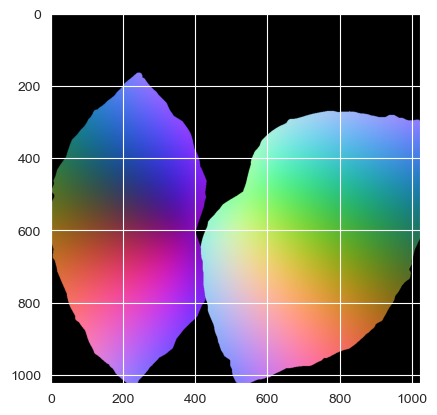

In [13]:
# plt.imshow(np.nan_to_num(projected_coordinates) / np.max(np.max(np.nan_to_num(projected_coordinates), axis=0), axis=0))

In [19]:
maxp = np.array(np.max(projected_data[0], axis=0), dtype=np.float32)
maxp = np.clip((maxp - np.quantile(mapping_arr, 0.5)) / (np.max(mapping_arr - np.min(mapping_arr))), 0, 1)
maxp = np.array(np.rint(maxp * 255), dtype=np.uint8)
# plt.imshow(maxp, cmap="gray")
# plt.show()
tifffile.imwrite(base_path / "long2b.tif", maxp, imagej=True)

C:\Users\Harrison\AppData\Local\Temp\ipykernel_32268\1904864143.py:3: RuntimeWarning: invalid value encountered in cast
  maxp = np.array(np.rint(maxp * 255), dtype=np.uint8)


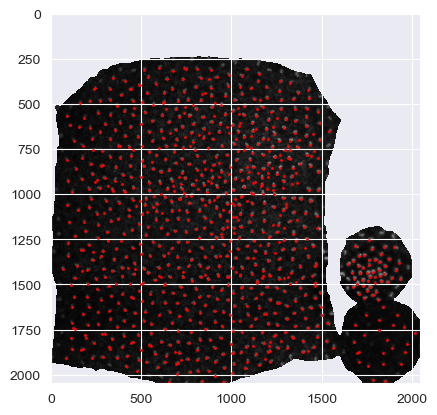

In [37]:
from skimage.filters import difference_of_gaussians
from skimage.feature import peak_local_max

dog = difference_of_gaussians(maxp, 4, 10)
peaks = peak_local_max(dog, min_distance=5, threshold_abs=15)

plt.imshow(maxp, cmap="gray")
plt.scatter(peaks[:, 1], peaks[:, 0], c="red", s=1)